## Calculate IoU for repeated surveys

Coleman et al. (2018) ran ADS-style surveys in the same location, at the same time, by multiple observers. This gives us a great opportunity to estimate how consistent observers are when looking at the same mortality. To do so, we will calculate pairwise IoU for all observers in the dataset.

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from itertools import combinations

In [2]:
polys = gpd.read_file("../data_in/coleman_repeatability/repeatability_polys_merge.gpkg")
area  = gpd.read_file("../data_in/coleman_repeatability/repeatability_study_area.gpkg")

polys = polys.clip(area)
polys.head()

,OBJECTID,DAMAGE_AREA_ID,CREATED_DATE,MODIFIED_DATE,FEATURE_USER_ID,OBSERVATION_USER_ID,REGION_ID,LABEL,HOST_CODE,HOST,...,AREA_TYPE,OBSERVATION_ID,PHOTOS,EXTRACTED_DATE,ACRES,SHAPE_Length,SHAPE_Area,layer,path,geometry
38,1,{8481b489-4fe4-4330-ae87-ed6c0f3135c1},2017-08-02 14:24:25+00:00,2017-08-02 14:24:25+00:00,dryerson_usfs,dryerson_usfs,3,DFB-3,202.0,202 - Douglas-fir,...,POLYGON,{289013d0-ee3c-4f91-9a46-8f7a08174fe6},None,2017-08-10 15:15:32+00:00,NaN,363.363787,9956.588680,dryerson_poly_utm13,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...,"POLYGON ((370668.537 3894532.104, 370649.737 3..."
15,16,{7ecf74ee-5097-4cd3-904b-c5cf225326b2},2017-08-09 14:01:56+00:00,2017-08-09 14:01:56+00:00,Cgtischler_usfs,Cgtischler_usfs,3,DFB-4,202.0,202 - Douglas-fir,...,POLYGON,{38793599-3ab5-49fc-971e-da49d67d0abf},None,2017-08-18 08:41:26+00:00,NaN,565.135545,17783.216231,ctischler_poly_utm13,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...,"POLYGON ((370563.31 3894726.626, 370585.096 38..."
61,24,{15ef5753-36f2-4ebf-b433-82eab1c565aa},2017-08-02 14:23:32+00:00,2017-08-02 14:23:32+00:00,dryerson_usfs,dryerson_usfs,3,DFB-3,202.0,202 - Douglas-fir,...,POLYGON,{b5732550-6b25-4044-9834-6b40db92e4a2},None,2017-08-10 15:15:32+00:00,NaN,396.546456,11377.489837,dryerson_poly_utm13,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...,"POLYGON ((370564.409 3894955.601, 370593.197 3..."
127,34,{05223b78-4ac7-41f7-815e-dc1a6a928b8f},2017-08-02 14:24:37+00:00,2017-08-02 14:24:37+00:00,twcoleman_usfs,twcoleman_usfs,3,DFB-3,202.0,202 - Douglas-fir,...,POLYGON,{60c1dbe6-0416-4323-95d2-83acf5aca629},None,2017-08-31 11:32:59+00:00,NaN,609.011816,21255.023827,tcoleman_poly_aerial_utm13,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...,"POLYGON ((370517.359 3894998.422, 370484.518 3..."
55,18,{582525e1-6cb9-44f4-862a-37f6faebaf8a},2017-08-02 14:23:47+00:00,2017-08-02 14:23:47+00:00,dryerson_usfs,dryerson_usfs,3,DFB-4,202.0,202 - Douglas-fir,...,POLYGON,{5056ecd7-71eb-424f-8c71-1f26f66b59ec},None,2017-08-10 15:15:32+00:00,NaN,482.090736,16996.481452,dryerson_poly_utm13,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...,"POLYGON ((369964.815 3895259.186, 369992.461 3..."


Dissolve by layer so that we don't double-count areas with overlapping polygons from the same observer.

In [3]:
polys_dissolve = polys.dissolve(by="layer").reset_index()
print(polys_dissolve.shape)
polys_dissolve.head()

(4, 31)


,layer,geometry,OBJECTID,DAMAGE_AREA_ID,CREATED_DATE,MODIFIED_DATE,FEATURE_USER_ID,OBSERVATION_USER_ID,REGION_ID,LABEL,...,OBSERVATION_COUNT,COLLECTION_MODE,AREA_TYPE,OBSERVATION_ID,PHOTOS,EXTRACTED_DATE,ACRES,SHAPE_Length,SHAPE_Area,path
0,ctischler_poly_utm13,"MULTIPOLYGON (((371581.142 3894476.453, 371600...",16,{7ecf74ee-5097-4cd3-904b-c5cf225326b2},2017-08-09 14:01:56+00:00,2017-08-09 14:01:56+00:00,Cgtischler_usfs,Cgtischler_usfs,3,DFB-4,...,SINGLE,Aerial_Survey,POLYGON,{38793599-3ab5-49fc-971e-da49d67d0abf},None,2017-08-18 08:41:26+00:00,NaN,565.135545,17783.216231,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...
1,dryerson_poly_utm13,"MULTIPOLYGON (((370674.144 3894598.643, 370686...",1,{8481b489-4fe4-4330-ae87-ed6c0f3135c1},2017-08-02 14:24:25+00:00,2017-08-02 14:24:25+00:00,dryerson_usfs,dryerson_usfs,3,DFB-3,...,SINGLE,Aerial_Survey,POLYGON,{289013d0-ee3c-4f91-9a46-8f7a08174fe6},None,2017-08-10 15:15:32+00:00,NaN,363.363787,9956.588680,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...
2,tcoleman_poly_aerial_utm13,"MULTIPOLYGON (((370477.253 3895057.346, 370462...",34,{05223b78-4ac7-41f7-815e-dc1a6a928b8f},2017-08-02 14:24:37+00:00,2017-08-02 14:24:37+00:00,twcoleman_usfs,twcoleman_usfs,3,DFB-3,...,SINGLE,Aerial_Survey,POLYGON,{60c1dbe6-0416-4323-95d2-83acf5aca629},None,2017-08-31 11:32:59+00:00,NaN,609.011816,21255.023827,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...
3,tzegler_poly_utm13,"MULTIPOLYGON (((371214.591 3894103.104, 371214...",10,{0d768915-7d5f-4eb4-b2a0-6b0715160ad5},2017-08-09 13:54:22+00:00,2017-08-09 13:54:22+00:00,tzegler_EMNRD,tzegler_EMNRD,3,DFB-3,...,SINGLE,Aerial_Survey,POLYGON,{df270218-2cb3-457a-a016-56ea255d5682},None,2017-08-18 08:41:26+00:00,NaN,1473.355947,97308.156079,C:/Users/rsgal/Downloads/Sandia_2017_Repeatabi...


In [4]:
n_observers = polys_dissolve.shape[0]
n_pairs = int(n_observers * (n_observers-1) / 2)
iou = np.zeros(n_pairs)

for i, (a, b) in enumerate(combinations(polys_dissolve.layer, 2)):
    layer_a = polys_dissolve[polys_dissolve.layer == a]
    layer_b = polys_dissolve[polys_dissolve.layer == b]

    # Calculate intersection
    intersect = gpd.overlay(layer_a, layer_b, how="intersection")
    union     = gpd.overlay(layer_a, layer_b, how="union")

    i_area = intersect.area.sum()
    u_area = union.area.sum()

    # Calculate iou
    iou[i] = i_area / u_area

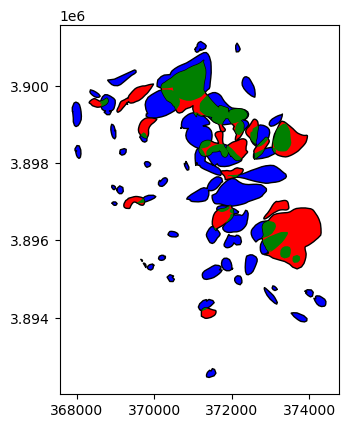

In [5]:
# Plot example of the polygons
fig, ax = plt.subplots()
layer_a.plot(ax=ax, color="blue", edgecolor="black")
layer_b.plot(ax=ax, color="red", edgecolor="black")
intersect.plot(ax=ax, color="green")
plt.show()

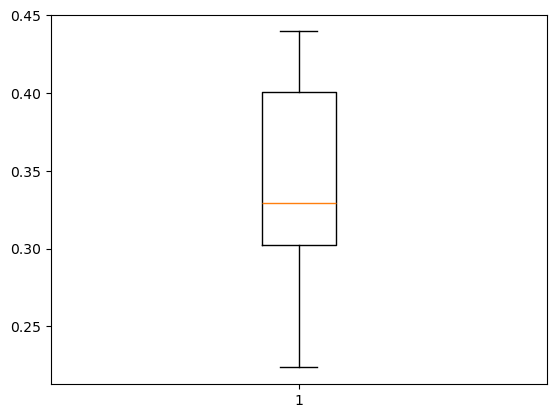

In [6]:
plt.boxplot(iou)
plt.show()